# Explore: Web Coverage Processing Service

This notebook explores use of WCPS for complex raster array query operations. It makes use of async code utilized by SNAP's data API for making the requests, although that is not necessary and other packages like `requests` would work just fine.

In [28]:
import io
import time
import requests
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from urllib.parse import quote

# base URL for WCPS queries
base_url = "http://zeus.snap.uaf.edu:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&request={}"

In [29]:
def request(url):
    resp = requests.get(url)
    return resp.content

#### Exploring some WCPS functions

In [30]:
# imageCrsDomain function
wcps_query = quote('ProcessCoverages&query=for $c in (iem_ar5_2km_taspr_seasonal) return imageCrsDomain($c)')
out = request(base_url.format(wcps_query))
print(out)

# imageCrsDomain function with subsetting on an axis
wcps_query = quote('ProcessCoverages&query=for $c in (iem_ar5_2km_taspr_seasonal) return imageCrsDomain($c[decade(6:8)])')
out = request(base_url.format(wcps_query))
print(out)

b'(0:8,0:3,0:2,0:2,0:1,0:3217,0:1185)'
b'(6:8,0:3,0:2,0:2,0:1,0:3217,0:1185)'


In [31]:
# id... doesn't work?
wcps_query = quote('ProcessCoverages&query=for $c in (iem_ar5_2km_taspr_seasonal) return id($c)')

# identifier
wcps_query = quote('ProcessCoverages&query=for $c in (iem_ar5_2km_taspr_seasonal) return identifier($c)')
out = request(base_url.format(wcps_query))
print("identifier():  ", out)

# crs... doesn't work?
wcps_query = quote('ProcessCoverages&query=for $c in (iem_ar5_2km_taspr_seasonal) return crs($c)')

identifier():   b'iem_ar5_2km_taspr_seasonal'


#### Average subset of grid over decades for single model/scenario/season

Computes the pixel-wise average for X = (200000, 1000000) and Y = (200000, 1000000), model = 0, scenario = 0, season = 0

Elapsed time: 0s
<xarray.Dataset>
Dimensions:  (varname: 2, X: 401, Y: 401)
Coordinates:
  * X        (X) float64 -1e+06 -9.982e+05 -9.962e+05 ... -2.022e+05 -2.002e+05
  * Y        (Y) float64 9.994e+05 9.974e+05 9.954e+05 ... 2.014e+05 1.994e+05
  * varname  (varname) float64 0.0 1.0
Data variables:
    Gray     (varname, X, Y) float64 ...
Attributes:
    Title:    Seasonal-decadal summaries of AR5 temperature and precipitation...


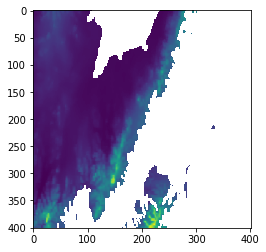

In [27]:
model = 0
scenario = 0
season = 0
x1 = -1000000
x2 = -200000
y1 = 200000
y2 = 1000000
d1 = 6
d2 = 8

# current working solution for averaging is to use a 
#   sum condenser and divide by number of time slices
wcps_query = quote((
    'ProcessCoverages&query='
    f'for $c in (iem_ar5_2km_taspr_seasonal) return encode( (condense + over $t decade({d1}:{d2}) '
    f'using $c[decade($t),model({model}),scenario({scenario}),season({season}),'
    f'X({x1}:{x2}),Y({y1}:{y2})] ) / {len(np.arange(d1, d2 + 1))}, "application/netcdf")'
))

netcdf_bytes = request(base_url.format(wcps_query))
ds = xr.open_dataset(io.BytesIO(netcdf_bytes))
print(ds)

plt.imshow(ds["Gray"].sel(varname=0).values)

Verify that this is indeed the average over the specified values:

In [57]:
wcs_query = (
    "GetCoverage&COVERAGEID=iem_ar5_2km_taspr_seasonal"
    "&SUBSET=decade(6,8)&SUBSET=season(0)&SUBSET=model(0)&SUBSET=scenario(0)"
    "&SUBSET=X(-1000000,-200000)&SUBSET=Y(200000,1000000)&FORMAT=application/netcdf"
)

netcdf_bytes = request(base_url.format(wcs_query))
test_ds = xr.open_dataset(io.BytesIO(netcdf_bytes))

arr1 = ds.Gray.sel(varname=0).values
arr2 = test_ds.Gray.sel(varname=0).values.mean(axis=0)
arr1[np.isnan(arr1)] = -9999
arr2[np.isnan(arr2)] = -9999

print("Arrays are exactly the same: ", np.all(arr1 == arr2))
print("Arrays are only different due to rounding: ", np.all(np.float32(arr1) == arr2))
print((
    "Note: data types are different.\n"
    f"  WCPS query returned data type: {arr1.dtype}\n"
    f"  WCS returned data type: {arr2.dtype}"
))

Arrays are exactly the same:  False
Arrays are only different due to rounding:  True
Note: data types are different.
  WCPS query returned data type: float64
  WCS returned data type: float32


##### Entire domain...

Computes the same average as above but for the entire domain.

<xarray.Dataset>
Dimensions:  (varname: 2, X: 3218, Y: 1186)
Coordinates:
  * X        (X) float64 -2.172e+06 -2.17e+06 -2.168e+06 ... 4.26e+06 4.262e+06
  * Y        (Y) float64 2.547e+06 2.545e+06 2.543e+06 ... 1.794e+05 1.774e+05
  * varname  (varname) float64 0.0 1.0
Data variables:
    Gray     (varname, X, Y) float64 ...
Attributes:
    Title:    Seasonal-decadal summaries of AR5 temperature and precipitation...
Elapsed time: 2s

<xarray.Dataset>
Dimensions:  (varname: 2, X: 3218, Y: 1186)
Coordinates:
  * X        (X) float64 -2.172e+06 -2.17e+06 -2.168e+06 ... 4.26e+06 4.262e+06
  * Y        (Y) float64 2.547e+06 2.545e+06 2.543e+06 ... 1.794e+05 1.774e+05
  * varname  (varname) float64 0.0 1.0
Data variables:
    Gray     (varname, X, Y) float64 ...
Attributes:
    Title:    Seasonal-decadal summaries of AR5 temperature and precipitation...


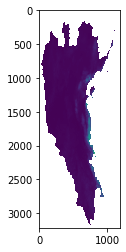

In [60]:
# running into some memory limits with rasdaman so slicing parts of domain
season = 0
model = 0
scenario = 0
d1 = 6
d2 = 8

# current working solution for averaging is to use a 
#   sum condenser and divide by number of time slices
wcps_query = quote((
    'ProcessCoverages&query='
    f'for $c in (iem_ar5_2km_taspr_seasonal) return encode( (condense + over $t decade({d1}:{d2}) '
    f'using $c[decade($t),season(0),model(0),scenario(0)] ) / {len(np.arange(d1, d2 + 1))}, "application/netcdf")'
))

start_time = time.time()
netcdf_bytes = request(base_url.format(wcps_query))
ds = xr.open_dataset(io.BytesIO(netcdf_bytes))
print(ds)

print(f"Elapsed time: {round(time.time() - start_time)}s\n")
print(ds)

plt.imshow(ds["Gray"].sel(varname=0).values)    